# Basic usage of configuration based StandardAnalyzer/BeamAnalyzer

This notebook demonstrates how the basic intended usage of the image_analysis module. 

Note, this module works best in conjuction with GEECS-Data-Utils also installed. See that project documentation to get started with it 

**Setup**

Import the minimal set of functions you need. Note, there are module level loggers which can display lots of information useful for understanding/troubleshooting the workflows. For these examples, the image_analysis module logger silences info/debug logging.

In [1]:
from geecs_data_utils.scan_data import ScanData
from image_analysis.offline_analyzers.beam_analyzer import BeamAnalyzer
from image_analysis.config_loader import set_config_base_dir

import logging

logging.getLogger("image_analysis").setLevel(logging.WARNING)

set_config_base_dir("/path/to/image_analysis_configs")

Create a ScanData object for easy access to the data

In [2]:
sd = ScanData.from_date(year=2025, month=9, day=24, number=13, experiment="Thomson")

A BeamAnalyzer object is instantiated with name of camera config yaml in the base directory (defined above). It makese sense to have these config files named after the devices (though not strictly required).

You can use ScanData to find expected paths to files. As an example, select a test image using the 'expected_path' entry from the ScanData dataframe. Note, we are re-using the dev_name to find the camera_config (which happens in the BeamAnalyzer constructor) and as way to the path to test image from ScanData. But, there is nothing that is intrinsically linked between these two. In other words, the BeamAnalyzer doesn't instinctively 'know' paths to the images it is designed to analyze. 

The 'use_interactive' flag can be toggled to dispaly the final image. The default for this flag is 'false' so that scripting and analyzing many images doesn't display the iamge

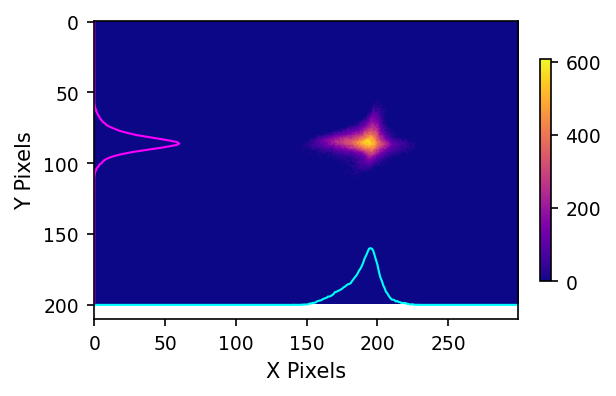

In [3]:
dev_name = "HTT-C-ASSERTHighR"
analyzer = BeamAnalyzer(dev_name)
file_path = sd.data_frame[f"{dev_name}_expected_path"][10]
analyzer.use_interactive = True
result = analyzer.analyze_image_file(file_path)

The processing pipeline can be adjusted as needed by accessing the various config_models and changing them as desired. Below, an are various examples, starting with increasing the background level which is updated with the update_config method. Of course, all config settings can be adjusted directly in the config files.

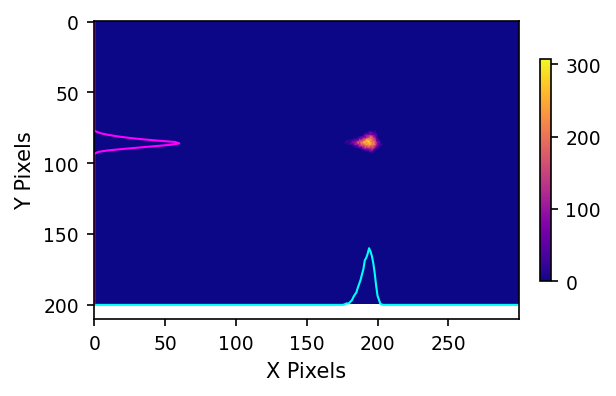

In [4]:
from image_analysis.processing import config_models as cfg

new_bkg = cfg.BackgroundConfig()
new_bkg.level = 400

analyzer.update_config(background=new_bkg)

result = analyzer.analyze_image_file(file_path)

You can reload the entire camera_config to reset the analyzer to the default configuration

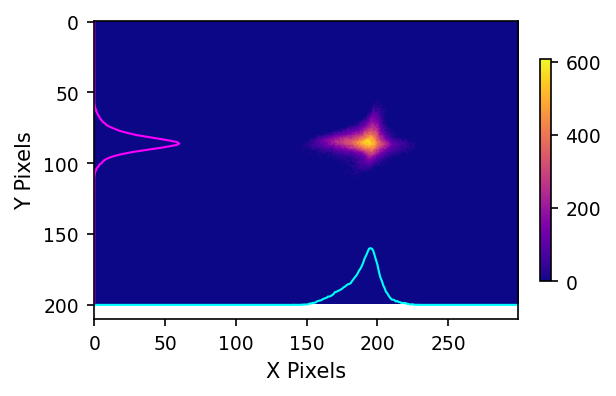

In [5]:
from image_analysis.config_loader import load_camera_config

camera_cfg = load_camera_config(dev_name)
analyzer.update_config(camera=camera_cfg)

result = analyzer.analyze_image_file(file_path)

A static circular mask can be applied to the image.

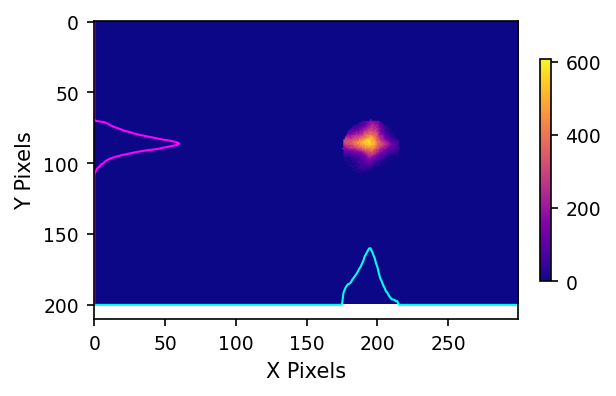

In [6]:
new_circ = cfg.CircularMaskConfig()
new_circ.center = (195, 90)
new_circ.radius = 20
new_circ.enabled = True

analyzer.update_config(circular_mask=new_circ)

result = analyzer.analyze_image_file(file_path)

Various transformations are available. Note, these are applied after ROI and masking

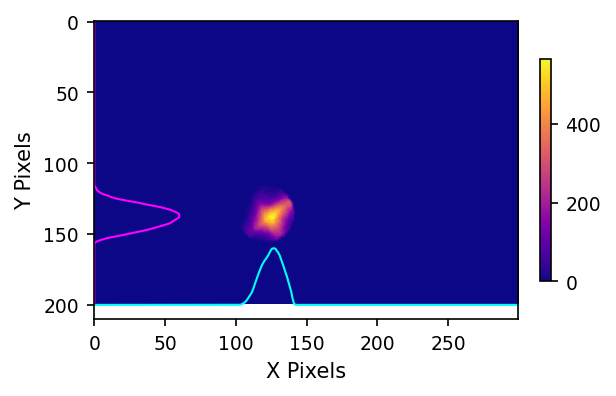

In [7]:
new_trs = cfg.TransformConfig()
new_trs.flip_horizontal = True
new_trs.flip_vertical = True
new_trs.rotation_angle = 40

analyzer.update_config(transforms=new_trs)

result = analyzer.analyze_image_file(file_path)

BeamAnalyzer performs calculates some basic stats from the image which are contained in 'result'

In [11]:
result["analyzer_return_dictionary"]

{'HTT-C-ASSERTHighR_image_total': 199936.22374132543,
 'HTT-C-ASSERTHighR_image_peak_value': 566.5037303210308,
 'HTT-C-ASSERTHighR_x_CoM': 125.17429448346756,
 'HTT-C-ASSERTHighR_x_rms': 7.41297261291362,
 'HTT-C-ASSERTHighR_x_fwhm': 20.81371952875611,
 'HTT-C-ASSERTHighR_x_peak_location': 127,
 'HTT-C-ASSERTHighR_y_CoM': 137.8589452467952,
 'HTT-C-ASSERTHighR_y_rms': 7.389041743397248,
 'HTT-C-ASSERTHighR_y_fwhm': 20.995173268253396,
 'HTT-C-ASSERTHighR_y_peak_location': 138}

CameraConfig(name='HTT-C-ASSERTHighR', description='high resolution for electron beam profile analysis', camera_type=<CameraType.EBEAM_PROFILE: 'ebeam_profile'>, bit_depth=16, roi=ROIConfig(x_min=675, x_max=975, y_min=100, y_max=300), background=BackgroundConfig(enabled=True, type=<BackgroundType.DYNAMIC: 'dynamic'>, method=<BackgroundMethod.PERCENTILE_DATASET: 'percentile_dataset'>, level=0.0, percentile=5.0, outlier_threshold=2.0, file_path=None, auto_save_path=None, fallback=FallbackBackgroundConfig(method=<BackgroundMethod.CONSTANT: 'constant'>, level=100.0, file_path=None)), crosshair_masking=CrosshairMaskingConfig(enabled=False, crosshairs=[], mask_value=0.0, fiducial_cross1_location=None, fiducial_cross2_location=None, mask_size=None), circular_mask=CircularMaskConfig(enabled=True, center=(195, 90), radius=20, mask_outside=True, mask_value=0.0), thresholding=ThresholdingConfig(enabled=True, method=<ThresholdMethod.CONSTANT: 'constant'>, value=0.0, mode=<ThresholdMode.TO_ZERO: 't